Import libraries and disable warnings

In [ ]:
%pip install xgboost
%pip install plotly
%pip install wordcloud

import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = 'notebook_connected'

%matplotlib inline

In [2]:
df = pd.read_csv('consumer_complaints.csv', parse_dates = ['date_received', 'date_sent_to_company'], low_memory = False)
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511074
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511080
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,2013-09-18,Closed with explanation,Yes,No,510473
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,2013-08-30,Closed with explanation,Yes,Yes,510326
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,2013-08-30,Closed with explanation,Yes,Yes,511067


In [3]:
df.isna().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date_received                 555957 non-null  datetime64[ns]
 1   product                       555957 non-null  object        
 2   sub_product                   397635 non-null  object        
 3   issue                         555957 non-null  object        
 4   sub_issue                     212622 non-null  object        
 5   consumer_complaint_narrative  66806 non-null   object        
 6   company_public_response       85124 non-null   object        
 7   company                       555957 non-null  object        
 8   state                         551070 non-null  object        
 9   zipcode                       551452 non-null  object        
 10  tags                          77959 non-null   object        
 11  consumer_cons

In [5]:
faulty_zipcodes = 0
for i in range(len(df['zipcode'])):
    try:
        int(df['zipcode'][i])
    except:
        faulty_zipcodes += 1
        df['zipcode'][i] = np.NaN

print(f"There are {faulty_zipcodes} improperly formatted or NaN zipcodes")

There are 82069 improperly formatted or NaN zipcodes


In [6]:
drop_threshold = 0.10
cols_na_counts = df.isna().mean(axis=0)
cols_over_dt = cols_na_counts[cols_na_counts >= drop_threshold]
cols_over_dt

sub_product                     0.284774
sub_issue                       0.617557
consumer_complaint_narrative    0.879836
company_public_response         0.846887
zipcode                         0.147618
tags                            0.859775
consumer_consent_provided       0.777936
dtype: float64

Drop features and reformat data into numerical features

Drops due to unhelpfulness (if we use the ML model for our company, these categories are either unhelpful or will create data leakage):
* complaint_id
* company

Drops due to high NaN counts (> 10%):
* sub_product
* sub_issue
* consumer_complaint_narrative
* company_public_response
* zipcode
* tags
* consumer_consent_provided

Data reformatted:
* Yes/No columns converted from str to int: 'No' -> 0 and 'Yes' -> 1
* company_response_to_consumer converted from str to int: 'Closed' -> 1, otherwise str -> 0
* date_received and date_sent_to_company converted from DateTime to int as its ordinal value

In [7]:
# Drop data
col_drops = list(cols_over_dt.index) + ['company', 'complaint_id']
df = df.drop(col_drops, axis=1)

# Reformat data
df = df.replace(['Yes', 'No'], [1, 0])

# Change all types of closed cases to 1, unclosed cases to 0 (converts to numerical feature)
case_col = 'company_response_to_consumer'
df.loc[df[case_col].str.contains('Closed'), case_col] = 1
df.loc[df[case_col] != 1, case_col] = 0

# Change all datetime objects to ordinal value of date (converts to numerical feature)
date_cols = ['date_received', 'date_sent_to_company']
for date_col in date_cols:
    df[date_col] = df[date_col].apply(pd.Timestamp.toordinal)

Drop NaN rows for state column

In [8]:
df = df.dropna(subset=['state'])
df.isna().sum()

date_received                   0
product                         0
issue                           0
state                           0
submitted_via                   0
date_sent_to_company            0
company_response_to_consumer    0
timely_response                 0
consumer_disputed?              0
dtype: int64

In [9]:
dispute_category = ''
def get_disputes(row):
    return df[(df['consumer_disputed?'] == 1) & (df[dispute_category] == row[dispute_category])]['consumer_disputed?'].sum()

def get_frequency_df(dispute_category: str, data: pd.DataFrame = df) -> pd.DataFrame:
    cat_df = data[[dispute_category, 'issue', 'consumer_disputed?']].groupby([dispute_category]).count().reset_index()
    cat_df['consumer_disputed?'] = cat_df.apply(get_disputes, axis=1)
    cat_df['percent_disputes'] = cat_df.apply(lambda row: (row['consumer_disputed?'] / row['issue']) * 100, axis=1)
    return cat_df

In [10]:
dispute_category = 'product'
product_df = get_frequency_df(dispute_category)

fig = px.scatter(
    product_df,
    x='consumer_disputed?',
    y='percent_disputes',
    size='issue',
    color=dispute_category,
    title='Product vs Consumer Disputes',
    labels={
        'consumer_disputed?': 'Consumer Disputes',
        'percent_disputes': 'Percent of Complaints Disputed',
        'product': 'Product',
        'issue': 'Total Complaints',
    },
    range_x=[0, 45000],
    hover_name='product',
)
fig.show()

In [11]:
dispute_category = 'state'

state_abbr = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
    'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
    'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
    'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
    'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
]

usa_df = df[df[dispute_category].isin(state_abbr)][[dispute_category, 'issue', 'consumer_disputed?']]
usa_df = get_frequency_df(dispute_category, usa_df)

fig = px.choropleth(
    usa_df,
    locations=dispute_category,
    locationmode="USA-states",
    scope="usa",
    color='percent_disputes',
    color_continuous_scale="rdylgn_r",
    title='State vs Percentage of Consumer Disputes',
    labels={
        'consumer_disputed?': 'Consumer Disputes',
        'percent_disputes': 'Percent of Complaints Disputed',
        dispute_category: 'State',
    },
)
fig.show()

In [12]:
dispute_category = 'submitted_via'

sub_df = get_frequency_df(dispute_category)

fig = px.bar(
    sub_df,
    x=dispute_category,
    y='percent_disputes',
    title='Submition Method vs Percentage of Consumer Disputes',
    labels={
        'consumer_disputed?': 'Consumer Disputes',
        'percent_disputes': 'Percent of Complaints Disputed',
        dispute_category: 'Submitted Via',        
    },
)
fig.show()

(-0.5, 399.5, 199.5, -0.5)

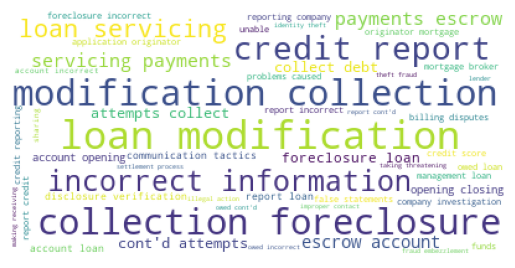

In [13]:
df.issue = df.issue.apply(str.lower)
words = ''
for issue in df.issue:
    words += issue + ' '

wordcloud = WordCloud(
    stopwords=set(STOPWORDS),
    min_font_size=5,
    background_color='white',
).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

In [14]:
df.nunique()

date_received                   1608
product                           11
issue                             95
state                             62
submitted_via                      6
date_sent_to_company            1557
company_response_to_consumer       2
timely_response                    2
consumer_disputed?                 2
dtype: int64

In [15]:
df = df.infer_objects()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551070 entries, 0 to 553096
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 551070 non-null  int64 
 1   product                       551070 non-null  object
 2   issue                         551070 non-null  object
 3   state                         551070 non-null  object
 4   submitted_via                 551070 non-null  object
 5   date_sent_to_company          551070 non-null  int64 
 6   company_response_to_consumer  551070 non-null  int64 
 7   timely_response               551070 non-null  int64 
 8   consumer_disputed?            551070 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 42.0+ MB


In [16]:
categorical_cols = ['product', 'issue', 'state', 'submitted_via']
ohe_df = df
for col in categorical_cols:
    col_ohe = pd.get_dummies(ohe_df[col], prefix=col)
    ohe_df = pd.concat((ohe_df, col_ohe), axis=1).drop(col, axis=1)
ohe_cols = ohe_df.columns
ohe_df = MinMaxScaler().fit_transform(ohe_df.to_numpy())
ohe_df = pd.DataFrame(ohe_df, columns=ohe_cols)

In [17]:
ohe_df.head()

,date_received,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,product_Bank account or service,product_Consumer Loan,product_Credit card,product_Credit reporting,product_Debt collection,...,state_WA,state_WI,state_WV,state_WY,submitted_via_Email,submitted_via_Fax,submitted_via_Phone,submitted_via_Postal mail,submitted_via_Referral,submitted_via_Web
0,0.397013,0.399502,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.397013,0.399502,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.397013,0.408836,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.397013,0.397013,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.397013,0.397013,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
target = 'consumer_disputed?'
X = ohe_df.drop(target, axis=1)
y = ohe_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [20]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 80.01%


In [21]:
cm

array([[88124,    38],
       [21998,    54]])

In [22]:
balanced_df = pd.concat([ohe_df[ohe_df['consumer_disputed?'] == 0][:111281], ohe_df[ohe_df['consumer_disputed?'] == 1]])
num_not_disp = balanced_df[balanced_df['consumer_disputed?'] == 0].shape[0]
num_disp = balanced_df[balanced_df['consumer_disputed?'] == 1].shape[0]
print(f"There are {num_disp} disputed complaints and {num_not_disp} non-disputed complaints")

There are 111281 disputed complaints and 111281 non-disputed complaints


In [23]:
target = 'consumer_disputed?'
X_b = ohe_df.drop(target, axis=1)
y_b = ohe_df[target]
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=0)

clf_b = xgb.XGBClassifier()
clf_b.fit(X_b_train, y_b_train)
y_b_pred = clf_b.predict(X_b_test)

accuracy = accuracy_score(y_b_test, y_b_pred)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 80.01%
